# Transformer Position Encoding
The transformer architecture uses stacked attention layers in place of CNNs or RNNs. This makes it easy to learn long-range dependencise but it contains no built in information about the relative positions of items in a sequence.

To give the model access to this information the transformer architecture uses adda a position encoding to the input.

This endocing is a vector of sines and cosines at each position, where each sine-cosine pair rotates at a different frequency.

Nearby locations will have similar position-encoding vectors.

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [7]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

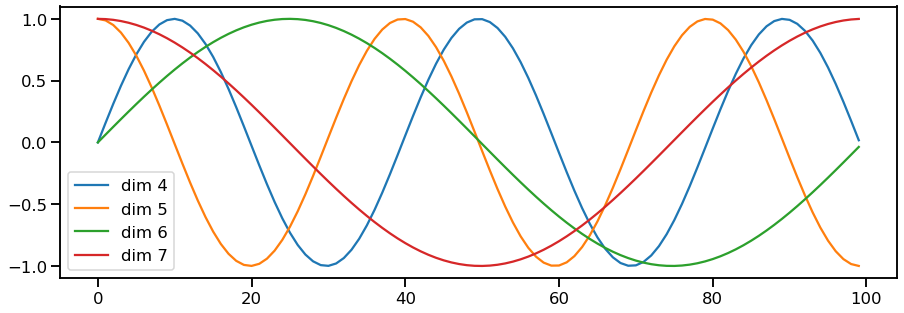

In [8]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [9]:
pos = 63
step= 3
dist = torch.dist(pe.pe.squeeze(0)[pos,], pe.pe.squeeze(0)[pos+step,], 2)
dist

tensor(2.3471)

In [10]:
d_model = 512
vocab = 512
word_embedding = Embeddings(d_model, vocab)
word_position = PositionalEncoding(d_model, 0)
x = torch.LongTensor(128).random_(0, vocab).unsqueeze(0)

In [11]:
x_embedding = word_embedding.forward(x)
x_position = word_position.forward(x_embedding)

In [12]:
x_embedding.size(1)

128

In [13]:
x_position.size()

torch.Size([1, 128, 512])

In [14]:
# Show the tensor.
def showTensor(aTensor):
    plt.figure(figsize=(16,16))
    plt.xlim(left=0, right=aTensor.size(1))
    plt.imshow(aTensor.numpy())
    plt.colorbar(orientation="horizontal")
    plt.show()

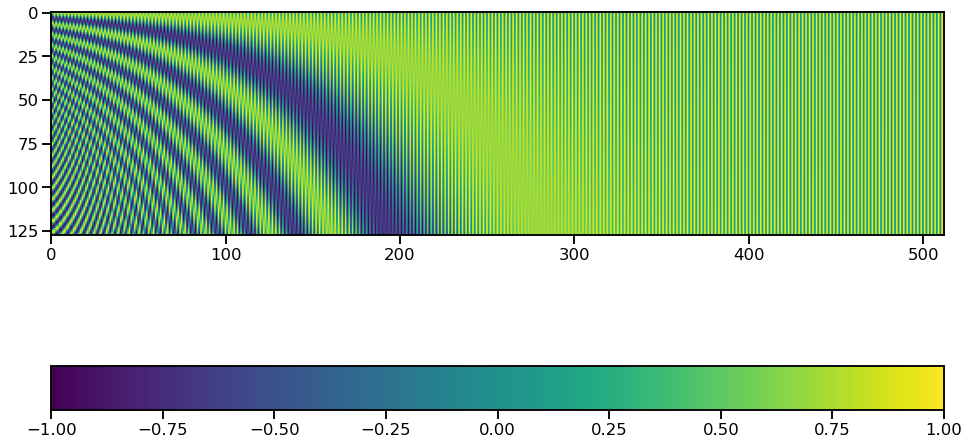

In [15]:
x_pos_numpy = x_position.squeeze(0).detach()
showTensor(x_pos_numpy)

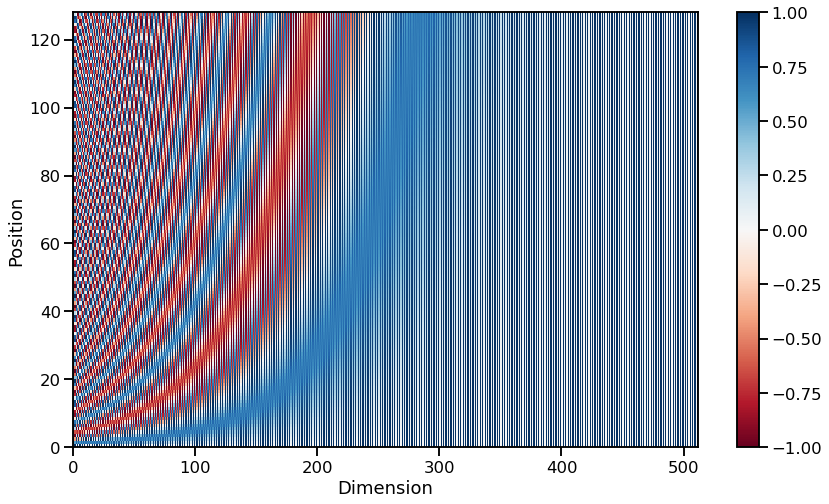

In [16]:
plt.figure(figsize=(14,8))
plt.pcolormesh(x_pos_numpy, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,512])
plt.ylabel('Position')
plt.xlabel('Dimension')
plt.colorbar()

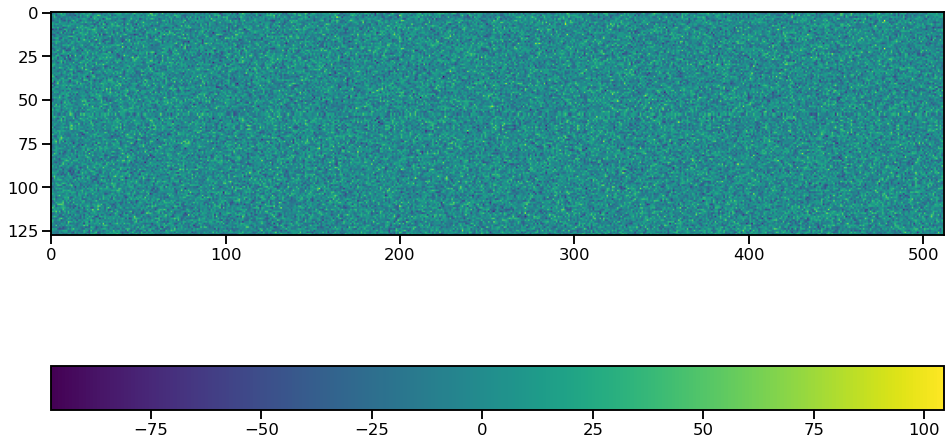

In [17]:
x_embed_numpy = x_embedding.squeeze(0).detach()
showTensor(x_embed_numpy)

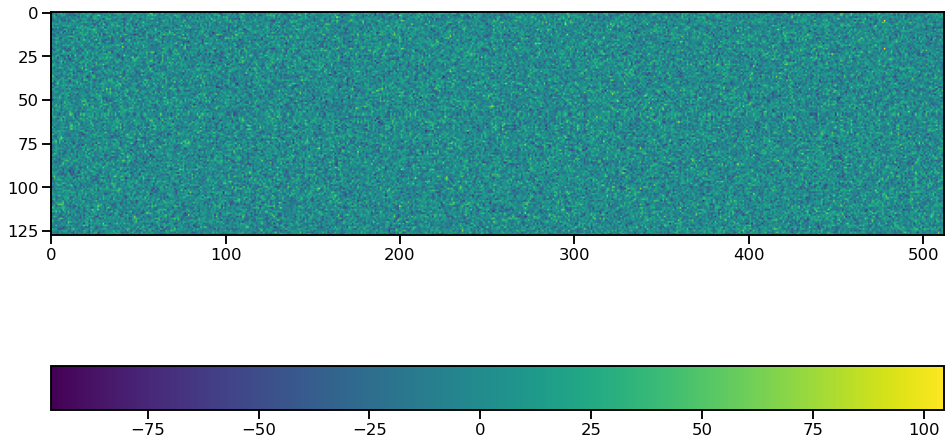

In [18]:
showTensor(x_embed_numpy + x_pos_numpy)

The angle rates range from 1 [rads/step] to min_rate [rads/step] over the vector depth.

Formula for angle rate:

$$angle\_rate_d = (min\_rate)^{d / d_{max}} $$

In [19]:
num_positions = 50
depth = 512
min_rate = 1/10000

assert depth%2 == 0, "Depth/dimensition must be even."
angle_rate_exponents = np.linspace(0,1,depth//2)
angle_rates = min_rate**(angle_rate_exponents)

In [20]:
len(angle_rate_exponents)

256

The resulting exponent goes from 0 to 1, causing the angle_rates to drop exponentially from 1 to min_rate.

Text(0, 0.5, 'Angle rate [rads/step]')

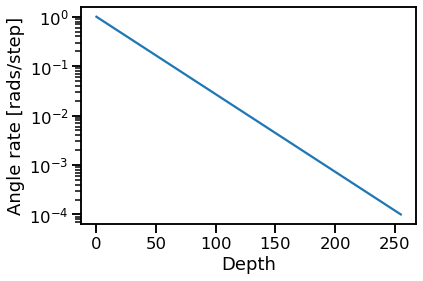

In [21]:
plt.semilogy(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')

Broadcasting a multiply over angle rates and positions gives a map of the position encoding angles as a function of depth.

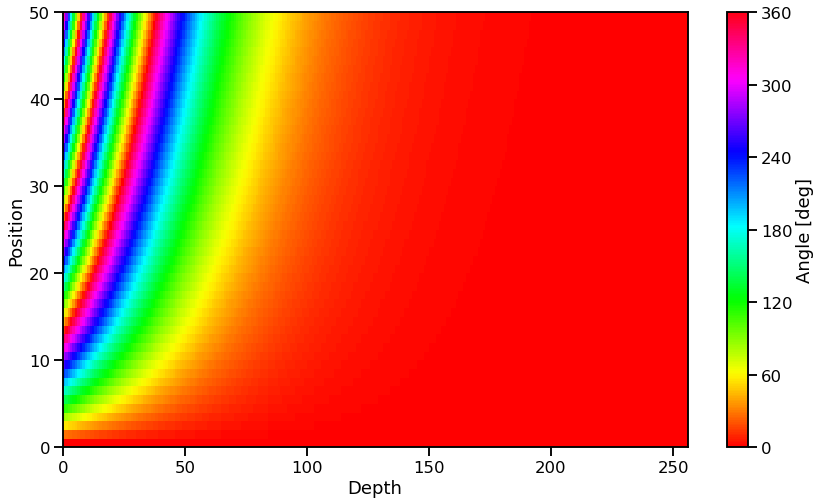

In [22]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

In [23]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1)

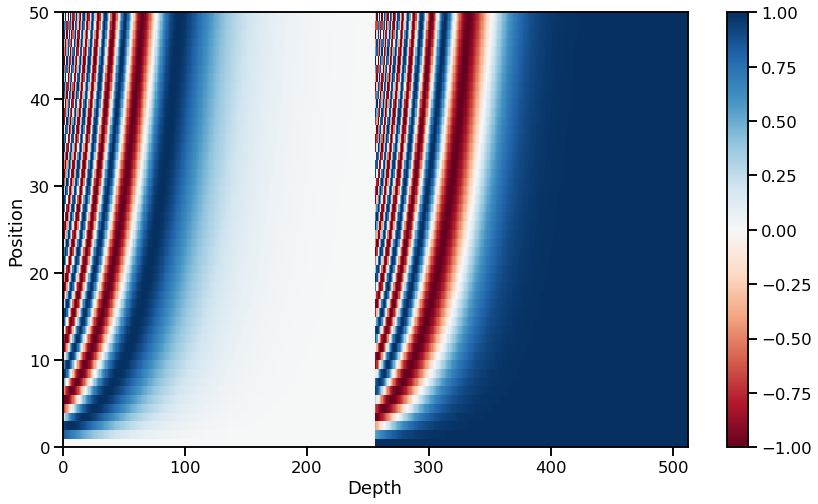

In [24]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

# Nearby positions
Nearby locations will have similar position-encoding vectors.

To demonstrate compare one position's encoding (here position 20) with each of the others:

In [25]:
pos_encoding_at_20 = pos_encoding[20]

dots = np.dot(pos_encoding,pos_encoding_at_20)
SSE = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

Regardless of how you compare the vecors, they are most similar 20, and clearly diverge as you move away:

Text(0.5, 0, 'Position')

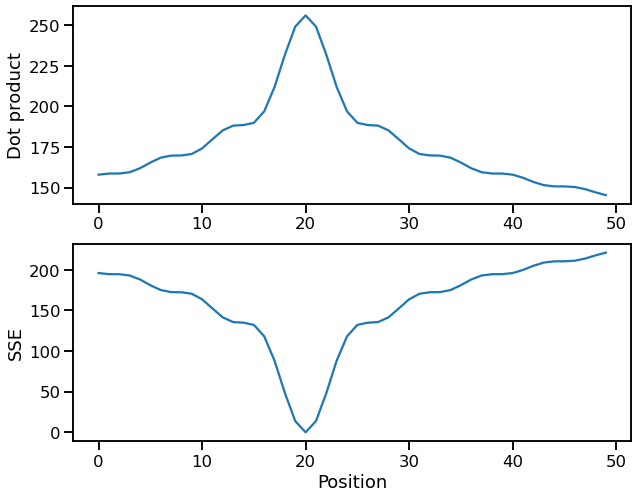

In [26]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(SSE)
plt.ylabel('SSE')
plt.xlabel('Position')

# Relative positions
The [paper](https://arxiv.org/pdf/1706.03762.pdf) explains, at the end of section 3.5, that any relative position encoding can be written as a linear function of the current position.

To demonstrate, this section builds a matrix that calculates these relative position encodings.

In [27]:
def transition_matrix(position_delta, angle_rates = angle_rates):
  # Implement as a matrix multiply:
  #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  
  # b
  angle_delta = position_delta*angle_rates

  # sin(b), cos(b)
  sin_delta = np.sin(angle_delta)
  cos_delta = np.cos(angle_delta)

  I = np.eye(len(angle_rates))
  
  # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)
  
  # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)

  return np.concatenate([update_sin, update_cos], axis=-1)

For example, create the matrix that calculates the position encoding 10 steps back, from the current position encoding:

In [28]:
position_delta = -10
update = transition_matrix(position_delta)

Applying this matrix to each position encoding vector gives position encoding vector from -10 steps away, resulting in a shifted position-encoding map:

Text(0.5, 0, 'Depth')

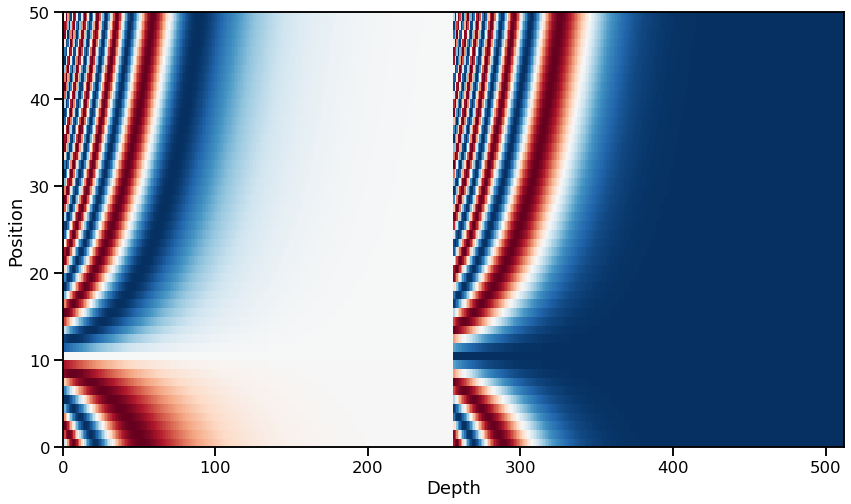

In [29]:
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')

This is accurate to numerical precision.

In [30]:
errors = np.dot(pos_encoding,update)[10:] - pos_encoding[:-10]
abs(errors).max()

5.4262150328554526e-15

# Self-Attention

\begin{equation}
Attention(Q, K, V) = softmax(\frac{QK^{T}}{\sqrt{d_k}}) * V
\end{equation}

其中 $Q \in \mathbb{R}^{n \times d_k}, K \in \mathbb{R}^{m \times d_k}, V \in \mathbb{R}^{m \times d_k}$. softmax 则是在 m 的那一维进行归一化。而自注意力，则是对于同一个 $X \in \mathbb{R}^{n \times d}$，通过不同的投影矩阵得到:



$$Q = X * W^Q, \; \text{where} \; W^Q \in \mathbb{R}^{d \times R'} $$

$$K = X * W^K, \; \text{where} \; W^K \in \mathbb{R}^{d \times R'} $$

$$V = X * W^V, \; \text{where} \; W^V \in \mathbb{R}^{d \times R'} $$

Particularly, each attention head operates on an input sequence, $x=(x_1, x_n, \ldots, x_n)$ of n elements where $x_i \in \mathbb{R}^{d}$, and computes a new sequence $z = (z_1, z_2, \ldots, z_n)$ of the same length where $z_i \in \mathbb{R}^{d}$. 

Each output element, $z_i$, is computed as weighted sum of a linearly transformed input element: 
\begin{equation}
z_i = \sum_{j = 1}^{n} \alpha_{ij}(x_jW^V)
\end{equation}

Each weight coefficient, $\alpha_{ij}$, is computed using a softmax function:
\begin{equation}
\alpha_{ij} = \frac{exp \; e_{ij}}{\sum_{k = 1}^{n} exp \; e_{ik}}
\end{equation}

And $e_{ij}$ is computed using a compatibility function that compares two input elements:
\begin{aligned}
e_{ij} &= \frac{Q_i \bigotimes K_{j}^T}{\sqrt{d}} = \frac{x_iW^Q \bigotimes (x_jW^K)^T}{\sqrt{d}}
\end{aligned}

## Absolute Position ([Paper](https://arxiv.org/abs/1706.03762))
An input vector ($x$) is summed of word embedding ($w$) and its corresponding absolute position ($p$): $x = w + p$
\begin{aligned}
e_{i,j} &= \frac{x_iW^Q \bigotimes (x_j W^K)^T}{\sqrt{d}} \\
&= \frac{(w_i + p_i)W^Q \bigotimes ((w_j + p_j)W^K)^T}{\sqrt{d}} \\
&= \frac{(w_iW^K) \bigotimes (w_j W^Q)^T}{\sqrt{d}} + \frac{(w_iW^K) \times (p_j W^Q)^T}{\sqrt{d}} + \frac{(p_i W^K) \bigotimes (w_j W^Q)^T}{\sqrt{d}} + \frac{(p_i W^K) \bigotimes (p_j W^Q)^T}{\sqrt{d}}
\end{aligned}

## Relative Position ([Paper](https://arxiv.org/abs/1803.02155))

In this sense, we model the input $x$ as a labeled, directed, fully-connected graph. The edge between input elements $x_i$ and $x_j$ is represented by two vectors $\color{red}{a^V_{ij}, a^K_{ij}} \in \mathbb{R}^d$


Each output element, $z_i$, is computed as weighted sum of a linearly transformed input element: 
\begin{equation}
z_i = \sum_{j = 1}^{n} \alpha_{ij}(x_jW^V + \color{red}{a_{ij}^V})
\end{equation}

Each weight coefficient, $\alpha_{ij}$, is computed using a softmax function:
\begin{equation}
\alpha_{ij} = \frac{exp \; e_{ij}}{\sum_{k = 1}^{n} exp \; e_{ik}}
\end{equation}

And $e_{ij}$ is computed using a compatibility function that compares two input elements:
\begin{aligned}
e_{ij} &= \frac{Q_i \bigotimes K_{j}^T}{\sqrt{d}} = \frac{x_iW^Q \bigotimes (x_j W^K + \color{red}{a^K_{ij}})^T}{\sqrt{d}}
\end{aligned}

## Relative Position - T5 ([Paper](https://arxiv.org/abs/1910.10683))
And $e_{ij}$ is computed using a compatibility function that compares two input elements:
\begin{aligned}
e_{ij} &= \frac{Q_i \bigotimes K_{j}^T}{\sqrt{d}} = \frac{x_iW^Q \bigotimes (x_j W^K)^T}{\sqrt{d}} + \color{red}{b_{ij}}
\end{aligned}
For each pair of x_i and x_j, $b_{ij}$ is a learnable scalar and shared in all layers. 

## United Positional Encoding - TUPE ([Paper](https://arxiv.org/abs/2006.15595))
And $e_{ij}$ is computed using a compatibility function that compares two input elements:
\begin{aligned}
e_{ij} &= \frac{Q_i \bigotimes K_{j}^T}{\sqrt{d}} = \frac{x_iW^Q \bigotimes (x_j W^K)^T}{\sqrt{d}} \\
&= \frac{w_iW^Q \bigotimes (w_j W^K)^T}{\sqrt{d}} + \underset{\color{red}{Absolute Position}}{\frac{(p_i U^Q) \bigotimes (p_j U^K)^T}{\sqrt{d}}} + \underset{\color{red}{Relative Position}}{b_{ij}}
\end{aligned}

# Reference
1. [Python, Pytorch and Plotting](https://www.cs.virginia.edu/~vicente/recognition/notebooks/python_pytorch_plotting.html)
2. [Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)